# NeuroFusionGPT: Cross-Attention Fusion for Stress Detection

**Multimodal Transformer framework fusing EEG and ECG for stress classification.**

## Architecture
- **EEG Encoder**: Transformer encoder for brain signals
- **ECG Encoder**: MLP encoder for heart signals  
- **Cross-Attention Fusion**: Fuses both modalities
- **Classification Head**: Predicts unified stress levels

## Datasets
For this implementation, we use ECG stress labels as the target (5 classes: Calm → Severe Stress).  
EEG features are used as complementary neurological context.

**Note**: When you get stress-labeled EEG data (DEAP/SEED), both modalities will predict the same stress task.

## Before running
1. **Colab**: Upload `eeg_data.csv`, `ecg_train.csv`, `ecg_test.csv` to `My Drive/datasets/bindu/`
2. **Local**: Place CSVs in project root
3. Set runtime to GPU in Colab (Runtime → Change runtime type → GPU)

In [ ]:
# Setup paths
import os
try:
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_DIR = '/content/drive/MyDrive/datasets/bindu/'
    OUTPUT_DIR = '/content/drive/MyDrive/models/bindu/'
    IN_COLAB = True
except Exception:
    DATA_DIR = os.getcwd()
    OUTPUT_DIR = os.path.join(DATA_DIR, 'output')
    IN_COLAB = False

os.makedirs(OUTPUT_DIR, exist_ok=True)
FIG_DIR = os.path.join(OUTPUT_DIR, 'figures')
os.makedirs(FIG_DIR, exist_ok=True)

print('Data dir:', DATA_DIR)
print('Output dir:', OUTPUT_DIR)
print('In Colab:', IN_COLAB)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data dir: /content/drive/MyDrive/datasets/bindu/
Output dir: /content/drive/MyDrive/models/bindu/
In Colab: True


In [ ]:
# Imports
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    precision_score, recall_score, confusion_matrix,
    classification_report, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import math
import json
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)
print('PyTorch version:', torch.__version__)

Device: cuda
PyTorch version: 2.9.0+cu126


## 1. Load and Preprocess Data

Load EEG and ECG data. We'll create **aligned pairs** for fusion training.

In [ ]:
# Configuration
EEG_FEATURES = 16
ECG_FEATURES = 187
NUM_CLASSES = 5
CLASS_NAMES = ['Calm', 'Mild Stress', 'Moderate Stress', 'High Stress', 'Severe Stress']

BATCH_SIZE = 128
EPOCHS = 50
PATIENCE = 10
LEARNING_RATE = 3e-4

print(f'EEG Features: {EEG_FEATURES}')
print(f'ECG Features: {ECG_FEATURES}')
print(f'Classes: {NUM_CLASSES}')
print(f'Batch Size: {BATCH_SIZE}, Epochs: {EPOCHS}')

EEG Features: 16
ECG Features: 187
Classes: 5
Batch Size: 128, Epochs: 50


In [ ]:
# Load EEG data
def load_eeg_data(data_dir):
    for filename in ('eeg_data.csv', 'eed_data.csv'):
        path = os.path.join(data_dir, filename)
        if os.path.exists(path):
            df = pd.read_csv(path)
            feat_cols = [c for c in df.columns if c != 'y']
            X = df[feat_cols].values.astype(np.float32)
            y = df['y'].astype(int).values
            print(f'Loaded EEG from {filename}: {X.shape}, labels: {np.unique(y)}')
            return X, y
    raise FileNotFoundError('No eeg_data.csv or eed_data.csv found')

# Load ECG data
def load_ecg_data(data_dir):
    train_path = os.path.join(data_dir, 'ecg_train.csv')
    test_path = os.path.join(data_dir, 'ecg_test.csv')

    train_arr = np.loadtxt(train_path, delimiter=',')
    test_arr = np.loadtxt(test_path, delimiter=',')

    X_train = train_arr[:, :ECG_FEATURES].astype(np.float32)
    y_train = train_arr[:, ECG_FEATURES].astype(int)
    X_test = test_arr[:, :ECG_FEATURES].astype(np.float32)
    y_test = test_arr[:, ECG_FEATURES].astype(int)

    print(f'Loaded ECG train: {X_train.shape}, test: {X_test.shape}')
    print(f'ECG labels: {np.unique(y_train)}')
    return X_train, y_train, X_test, y_test

# Load data
X_eeg_all, y_eeg_all = load_eeg_data(DATA_DIR)
X_ecg_train_full, y_ecg_train_full, X_ecg_test, y_ecg_test = load_ecg_data(DATA_DIR)

Loaded EEG from eeg_data.csv: (8000, 16), labels: [0 1 2 3]
Loaded ECG train: (87554, 187), test: (21892, 187)
ECG labels: [0 1 2 3 4]


In [ ]:
# Create aligned dataset for fusion
# Strategy: Use ECG stress labels as target; pair with EEG samples
# For real deployment, you'd have synchronized EEG+ECG from same recording

# Split EEG to match ECG train/test sizes
n_train = len(X_ecg_train_full)
n_test = len(X_ecg_test)

# Randomly sample EEG to create pairs (in real scenario, they'd be synchronized)
np.random.seed(42)
train_indices = np.random.choice(len(X_eeg_all), size=n_train, replace=True)
test_indices = np.random.choice(len(X_eeg_all), size=n_test, replace=True)

X_eeg_train_full = X_eeg_all[train_indices]
X_eeg_test = X_eeg_all[test_indices]

# Use ECG labels as the unified stress target
y_train_full = y_ecg_train_full
y_test = y_ecg_test

print('\n=== Aligned Fusion Dataset ===')
print(f'Train: {n_train} paired samples (EEG {X_eeg_train_full.shape} + ECG {X_ecg_train_full.shape})')
print(f'Test: {n_test} paired samples')
print(f'Target: ECG stress labels (5 classes)')
print(f'Label distribution train:', np.bincount(y_train_full))
print(f'Label distribution test:', np.bincount(y_test))


=== Aligned Fusion Dataset ===
Train: 87554 paired samples (EEG (87554, 16) + ECG (87554, 187))
Test: 21892 paired samples
Target: ECG stress labels (5 classes)
Label distribution train: [72471  2223  5788   641  6431]
Label distribution test: [18118   556  1448   162  1608]


In [ ]:
# Normalize ECG features
scaler_ecg = StandardScaler()
X_ecg_train_full = scaler_ecg.fit_transform(X_ecg_train_full)
X_ecg_test = scaler_ecg.transform(X_ecg_test)

# EEG is already in reasonable range (BEED data), but can normalize if needed
scaler_eeg = StandardScaler()
X_eeg_train_full = scaler_eeg.fit_transform(X_eeg_train_full)
X_eeg_test = scaler_eeg.transform(X_eeg_test)

# Train/Val split
indices = np.arange(len(X_eeg_train_full))
train_idx, val_idx = train_test_split(indices, test_size=0.1, random_state=42, stratify=y_train_full)

X_eeg_train, X_eeg_val = X_eeg_train_full[train_idx], X_eeg_train_full[val_idx]
X_ecg_train, X_ecg_val = X_ecg_train_full[train_idx], X_ecg_train_full[val_idx]
y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]

print('\n=== Train/Val/Test Split ===')
print(f'Train: {len(y_train)} | Val: {len(y_val)} | Test: {len(y_test)}')

# Save scalers for application use
import joblib
joblib.dump(scaler_eeg, os.path.join(OUTPUT_DIR, 'scaler_eeg.pkl'))
joblib.dump(scaler_ecg, os.path.join(OUTPUT_DIR, 'scaler_ecg.pkl'))
print('Saved scalers to output folder')


=== Train/Val/Test Split ===
Train: 78798 | Val: 8756 | Test: 21892
Saved scalers to output folder


## 2. Exploratory Data Analysis

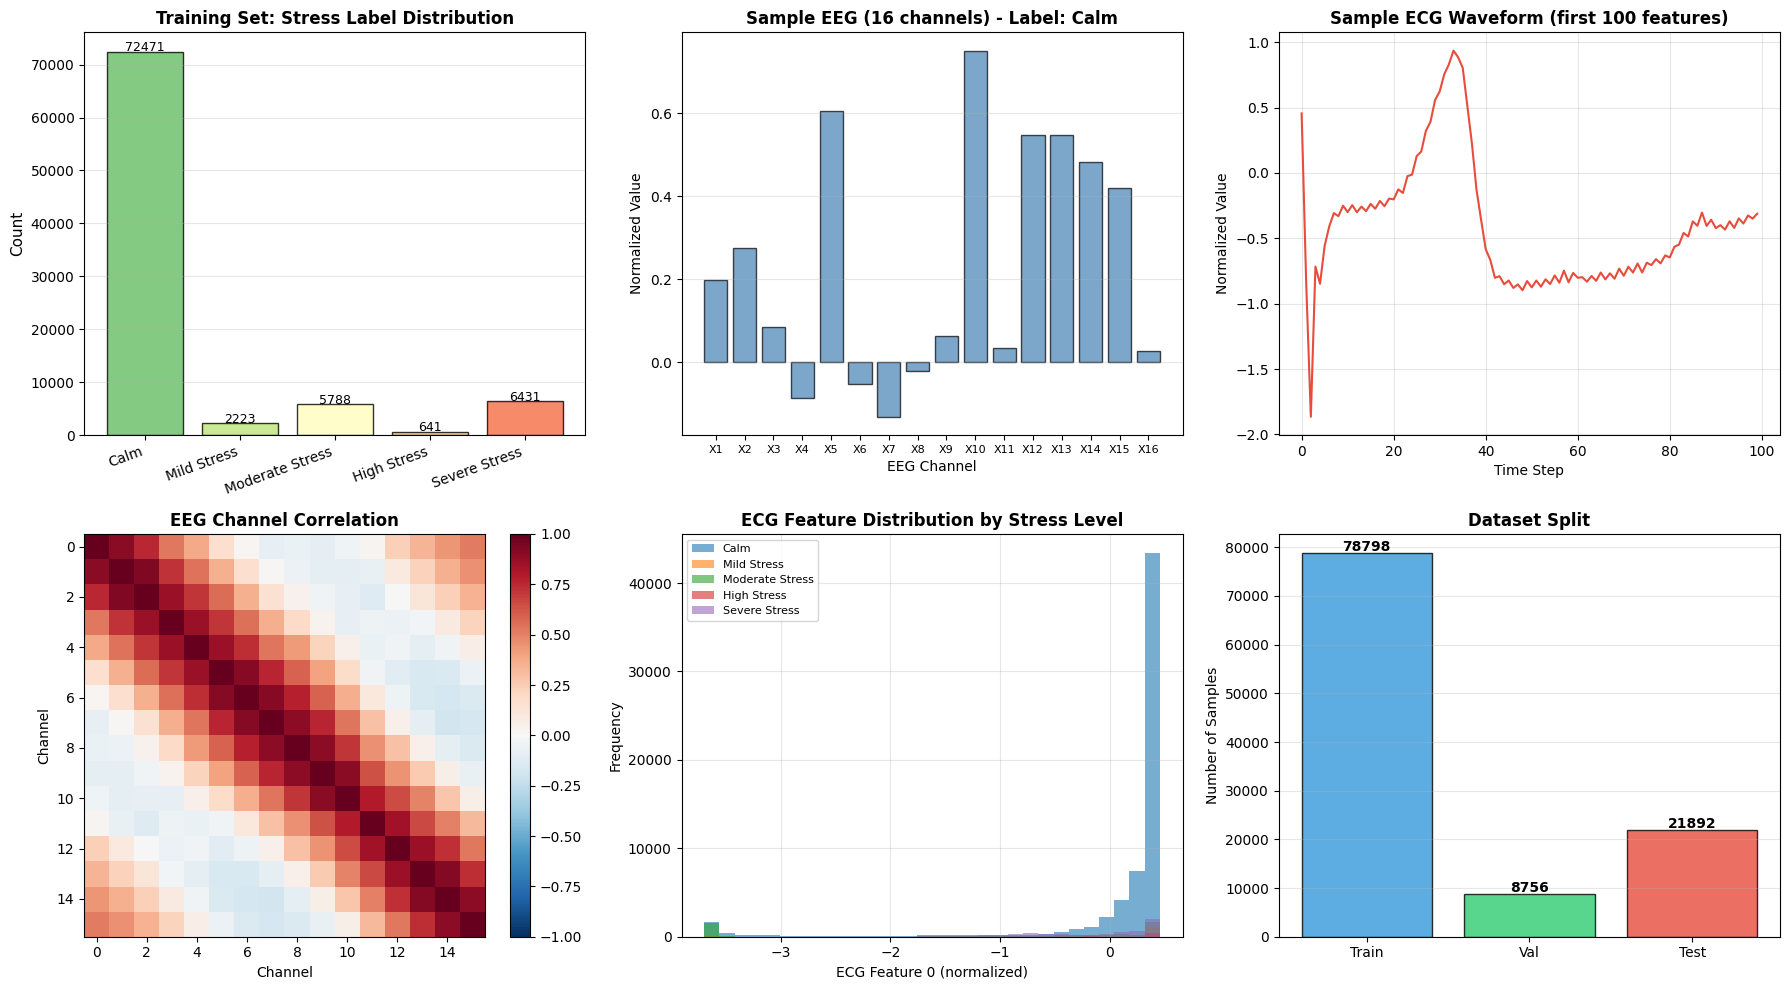

Saved: figures/data_eda.png


In [ ]:
# EDA: Label distribution and sample visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Label distribution
ax = axes[0, 0]
unique, counts = np.unique(y_train_full, return_counts=True)
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, NUM_CLASSES))
bars = ax.bar(CLASS_NAMES, counts, color=colors, edgecolor='black', alpha=0.8)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Training Set: Stress Label Distribution', fontsize=12, fontweight='bold')
ax.set_xticklabels(CLASS_NAMES, rotation=20, ha='right')
for b, c in zip(bars, counts):
    ax.text(b.get_x() + b.get_width()/2, b.get_height() + 50, str(c), ha='center', fontsize=9)
ax.grid(axis='y', alpha=0.3)

# 2. EEG sample (16 channels)
ax = axes[0, 1]
sample_idx = 0
ax.bar(range(EEG_FEATURES), X_eeg_train[sample_idx], color='steelblue', edgecolor='black', alpha=0.7)
ax.set_xlabel('EEG Channel')
ax.set_ylabel('Normalized Value')
ax.set_title(f'Sample EEG (16 channels) - Label: {CLASS_NAMES[y_train[sample_idx]]}', fontweight='bold')
ax.set_xticks(range(EEG_FEATURES))
ax.set_xticklabels([f'X{i+1}' for i in range(EEG_FEATURES)], fontsize=8)
ax.grid(axis='y', alpha=0.3)

# 3. ECG sample waveform (first 100 features)
ax = axes[0, 2]
ax.plot(X_ecg_train[sample_idx, :100], color='#e74c3c', linewidth=1.5)
ax.set_xlabel('Time Step')
ax.set_ylabel('Normalized Value')
ax.set_title(f'Sample ECG Waveform (first 100 features)', fontweight='bold')
ax.grid(alpha=0.3)

# 4. EEG correlation heatmap
ax = axes[1, 0]
corr_eeg = np.corrcoef(X_eeg_train[:1000].T)
im = ax.imshow(corr_eeg, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
ax.set_title('EEG Channel Correlation', fontweight='bold')
ax.set_xlabel('Channel')
ax.set_ylabel('Channel')
plt.colorbar(im, ax=ax)

# 5. ECG feature distribution by class (first feature)
ax = axes[1, 1]
for cls in range(NUM_CLASSES):
    mask = y_train == cls
    ax.hist(X_ecg_train[mask, 0], bins=30, alpha=0.6, label=CLASS_NAMES[cls])
ax.set_xlabel('ECG Feature 0 (normalized)')
ax.set_ylabel('Frequency')
ax.set_title('ECG Feature Distribution by Stress Level', fontweight='bold')
ax.legend(fontsize=8)
ax.grid(alpha=0.3)

# 6. Dataset size comparison
ax = axes[1, 2]
sizes = [len(y_train), len(y_val), len(y_test)]
ax.bar(['Train', 'Val', 'Test'], sizes, color=['#3498db', '#2ecc71', '#e74c3c'], alpha=0.8, edgecolor='black')
ax.set_ylabel('Number of Samples')
ax.set_title('Dataset Split', fontweight='bold')
for i, (label, size) in enumerate(zip(['Train', 'Val', 'Test'], sizes)):
    ax.text(i, size + 500, str(size), ha='center', fontsize=10, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'data_eda.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: figures/data_eda.png')

## 3. Multimodal Fusion Architecture

**Cross-Attention Fusion** as per proposal:
- EEG Encoder (Transformer) → eeg_embedding
- ECG Encoder (MLP) → ecg_embedding  
- Cross-Attention: EEG attends to ECG and vice versa
- Fused representation → Classifier → P(stress levels)

In [ ]:
# Dataset class for paired EEG + ECG
class MultimodalDataset(Dataset):
    def __init__(self, X_eeg, X_ecg, y):
        self.X_eeg = torch.FloatTensor(X_eeg)
        self.X_ecg = torch.FloatTensor(X_ecg)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X_eeg[idx], self.X_ecg[idx], self.y[idx]

train_dataset = MultimodalDataset(X_eeg_train, X_ecg_train, y_train)
val_dataset = MultimodalDataset(X_eeg_val, X_ecg_val, y_val)
test_dataset = MultimodalDataset(X_eeg_test, X_ecg_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f'Train batches: {len(train_loader)} | Val batches: {len(val_loader)} | Test batches: {len(test_loader)}')

Train batches: 616 | Val batches: 69 | Test batches: 172


In [ ]:
# Model components

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=200, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

class EEGEncoder(nn.Module):
    """Transformer encoder for EEG (16 channels as sequence)"""
    def __init__(self, input_dim=16, d_model=128, nhead=8, num_layers=3, dropout=0.1):
        super().__init__()
        self.embedding = nn.Linear(1, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=input_dim, dropout=dropout)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=256,
            dropout=dropout, activation='gelu', batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        # x: (batch, 16)
        x = x.unsqueeze(-1)  # (batch, 16, 1)
        x = self.embedding(x)  # (batch, 16, d_model)
        x = self.pos_encoder(x)
        x = self.transformer(x)  # (batch, 16, d_model)
        x = x.mean(dim=1)  # Global average pooling: (batch, d_model)
        return self.norm(x)

class ECGEncoder(nn.Module):
    """MLP encoder for ECG features"""
    def __init__(self, input_dim=187, hidden_dims=[256, 128], dropout=0.3):
        super().__init__()
        layers = []
        in_d = input_dim
        for h in hidden_dims:
            layers += [
                nn.Linear(in_d, h),
                nn.BatchNorm1d(h),
                nn.ReLU(),
                nn.Dropout(dropout)
            ]
            in_d = h
        self.encoder = nn.Sequential(*layers)

    def forward(self, x):
        # x: (batch, 187)
        return self.encoder(x)  # (batch, 128)

class CrossAttentionFusion(nn.Module):
    """Cross-attention between EEG and ECG embeddings"""
    def __init__(self, d_model=128, nhead=4, dropout=0.1):
        super().__init__()
        self.eeg_to_ecg_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.ecg_to_eeg_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.fusion = nn.Linear(d_model * 2, d_model)

    def forward(self, eeg_emb, ecg_emb):
        # Both: (batch, d_model)
        # Add sequence dim for attention
        eeg = eeg_emb.unsqueeze(1)  # (batch, 1, d_model)
        ecg = ecg_emb.unsqueeze(1)

        # EEG attends to ECG
        eeg_attended, _ = self.eeg_to_ecg_attn(eeg, ecg, ecg)
        eeg_out = self.norm1(eeg + eeg_attended).squeeze(1)

        # ECG attends to EEG
        ecg_attended, _ = self.ecg_to_eeg_attn(ecg, eeg, eeg)
        ecg_out = self.norm2(ecg + ecg_attended).squeeze(1)

        # Concatenate and fuse
        fused = torch.cat([eeg_out, ecg_out], dim=1)
        return self.fusion(fused)  # (batch, d_model)

class NeuroFusionGPT(nn.Module):
    """Complete multimodal fusion model"""
    def __init__(self, eeg_dim=16, ecg_dim=187, d_model=128, num_classes=5, dropout=0.2):
        super().__init__()
        self.eeg_encoder = EEGEncoder(eeg_dim, d_model)
        self.ecg_encoder = ECGEncoder(ecg_dim, hidden_dims=[256, d_model])
        self.fusion = CrossAttentionFusion(d_model)
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )

    def forward(self, eeg, ecg, return_embeddings=False):
        eeg_emb = self.eeg_encoder(eeg)
        ecg_emb = self.ecg_encoder(ecg)
        fused_emb = self.fusion(eeg_emb, ecg_emb)
        logits = self.classifier(fused_emb)

        if return_embeddings:
            return logits, {'eeg': eeg_emb, 'ecg': ecg_emb, 'fused': fused_emb}
        return logits

# Initialize model
model = NeuroFusionGPT(
    eeg_dim=EEG_FEATURES,
    ecg_dim=ECG_FEATURES,
    d_model=128,
    num_classes=NUM_CLASSES
).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print('\n=== NeuroFusionGPT Model ===')
print(f'Total parameters: {total_params:,}')
print(f'Trainable parameters: {trainable_params:,}')
print(f'Model size: ~{total_params * 4 / 1024**2:.2f} MB (float32)')


=== NeuroFusionGPT Model ===
Total parameters: 679,557
Trainable parameters: 679,557
Model size: ~2.59 MB (float32)


## 4. Training Setup

In [ ]:
# Loss and optimizer
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        p_t = torch.exp(-ce_loss)
        focal_loss = (1 - p_t) ** self.gamma * ce_loss

        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            focal_loss = alpha_t * focal_loss

        return focal_loss.mean()

# Compute class weights
class_counts = np.bincount(y_train, minlength=NUM_CLASSES)
class_weights = len(y_train) / (NUM_CLASSES * class_counts)
class_weights = torch.FloatTensor(class_weights).to(device)

criterion = FocalLoss(alpha=class_weights, gamma=2.0)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5
)

print(f'Class weights: {class_weights.cpu().numpy()}')
print(f'Using Focal Loss (gamma=2.0) with AdamW optimizer')
print(f'Initial LR: {LEARNING_RATE}')

Class weights: [ 0.24162643  7.875862    3.025456   27.312998    2.7228057 ]
Using Focal Loss (gamma=2.0) with AdamW optimizer
Initial LR: 0.0003


In [ ]:
# Evaluation function
def evaluate(model, loader, criterion):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    total_loss = 0

    with torch.no_grad():
        for eeg, ecg, labels in loader:
            eeg, ecg, labels = eeg.to(device), ecg.to(device), labels.to(device)

            logits = model(eeg, ecg)
            loss = criterion(logits, labels)
            total_loss += loss.item()

            probs = F.softmax(logits, dim=1)
            preds = logits.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    avg_loss = total_loss / len(loader)
    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    y_probs = np.array(all_probs)

    acc = accuracy_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    return avg_loss, acc, bal_acc, macro_f1, y_true, y_pred, y_probs

## 5. Training Loop

In [ ]:
# Training
history = []
best_val_f1 = 0
best_epoch = 0
patience_counter = 0

print('\n' + '='*80)
print('STARTING TRAINING')
print('='*80)

for epoch in range(EPOCHS):
    # Train
    model.train()
    train_loss = 0
    train_preds, train_labels = [], []

    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}')
    for eeg, ecg, labels in pbar:
        eeg, ecg, labels = eeg.to(device), ecg.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(eeg, ecg)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        train_loss += loss.item()
        preds = logits.argmax(dim=1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    train_loss /= len(train_loader)
    train_acc = accuracy_score(train_labels, train_preds)
    train_f1 = f1_score(train_labels, train_preds, average='macro', zero_division=0)

    # Validate
    val_loss, val_acc, val_bal_acc, val_f1, _, _, _ = evaluate(model, val_loader, criterion)

    # Scheduler step
    scheduler.step(val_f1)

    # Save history
    history.append({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'train_acc': train_acc,
        'train_f1': train_f1,
        'val_loss': val_loss,
        'val_acc': val_acc,
        'val_bal_acc': val_bal_acc,
        'val_f1': val_f1,
        'lr': optimizer.param_groups[0]['lr']
    })

    print(f'\nEpoch {epoch+1}/{EPOCHS}')
    print(f'  Train - Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | F1: {train_f1:.4f}')
    print(f'  Val   - Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | Bal Acc: {val_bal_acc:.4f} | F1: {val_f1:.4f}')
    print(f'  LR: {optimizer.param_groups[0]["lr"]:.6f}')

    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_epoch = epoch + 1
        patience_counter = 0

        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_f1': val_f1,
            'val_acc': val_acc,
            'history': history
        }, os.path.join(OUTPUT_DIR, 'best_fusion_model.pth'))

        print(f'  ✓ Best model saved! (Val F1: {val_f1:.4f})')
    else:
        patience_counter += 1
        print(f'  Patience: {patience_counter}/{PATIENCE}')

    if patience_counter >= PATIENCE:
        print(f'\nEarly stopping at epoch {epoch+1}')
        break

    print('-' * 80)

print('\n' + '='*80)
print(f'TRAINING COMPLETE - Best Val F1: {best_val_f1:.4f} at epoch {best_epoch}')
print('='*80)


STARTING TRAINING


Epoch 1/50: 100%|██████████| 616/616 [00:11<00:00, 52.87it/s, loss=0.5425]



Epoch 1/50
  Train - Loss: 0.3721 | Acc: 0.6764 | F1: 0.4748
  Val   - Loss: 0.2307 | Acc: 0.8828 | Bal Acc: 0.8373 | F1: 0.6640
  LR: 0.000300
  ✓ Best model saved! (Val F1: 0.6640)
--------------------------------------------------------------------------------


Epoch 2/50: 100%|██████████| 616/616 [00:11<00:00, 54.76it/s, loss=0.1245]



Epoch 2/50
  Train - Loss: 0.2594 | Acc: 0.7815 | F1: 0.5615
  Val   - Loss: 0.1954 | Acc: 0.8306 | Bal Acc: 0.8612 | F1: 0.6166
  LR: 0.000300
  Patience: 1/10
--------------------------------------------------------------------------------


Epoch 3/50: 100%|██████████| 616/616 [00:11<00:00, 54.37it/s, loss=0.4299]



Epoch 3/50
  Train - Loss: 0.2234 | Acc: 0.7942 | F1: 0.5799
  Val   - Loss: 0.1746 | Acc: 0.8132 | Bal Acc: 0.8648 | F1: 0.6086
  LR: 0.000300
  Patience: 2/10
--------------------------------------------------------------------------------


Epoch 4/50: 100%|██████████| 616/616 [00:11<00:00, 54.76it/s, loss=0.2283]



Epoch 4/50
  Train - Loss: 0.2015 | Acc: 0.8168 | F1: 0.6079
  Val   - Loss: 0.1921 | Acc: 0.6989 | Bal Acc: 0.8598 | F1: 0.5699
  LR: 0.000300
  Patience: 3/10
--------------------------------------------------------------------------------


Epoch 5/50: 100%|██████████| 616/616 [00:11<00:00, 53.80it/s, loss=0.0589]



Epoch 5/50
  Train - Loss: 0.1975 | Acc: 0.8320 | F1: 0.6224
  Val   - Loss: 0.1462 | Acc: 0.8519 | Bal Acc: 0.8823 | F1: 0.6449
  LR: 0.000300
  Patience: 4/10
--------------------------------------------------------------------------------


Epoch 6/50: 100%|██████████| 616/616 [00:11<00:00, 54.46it/s, loss=0.8715]



Epoch 6/50
  Train - Loss: 0.1791 | Acc: 0.8411 | F1: 0.6324
  Val   - Loss: 0.1524 | Acc: 0.8554 | Bal Acc: 0.8984 | F1: 0.6596
  LR: 0.000300
  Patience: 5/10
--------------------------------------------------------------------------------


Epoch 7/50: 100%|██████████| 616/616 [00:11<00:00, 54.21it/s, loss=0.5327]



Epoch 7/50
  Train - Loss: 0.1747 | Acc: 0.8512 | F1: 0.6456
  Val   - Loss: 0.1419 | Acc: 0.8746 | Bal Acc: 0.9044 | F1: 0.6870
  LR: 0.000300
  ✓ Best model saved! (Val F1: 0.6870)
--------------------------------------------------------------------------------


Epoch 8/50: 100%|██████████| 616/616 [00:11<00:00, 55.10it/s, loss=0.0249]



Epoch 8/50
  Train - Loss: 0.1619 | Acc: 0.8561 | F1: 0.6513
  Val   - Loss: 0.1538 | Acc: 0.8482 | Bal Acc: 0.8988 | F1: 0.6517
  LR: 0.000300
  Patience: 1/10
--------------------------------------------------------------------------------


Epoch 9/50: 100%|██████████| 616/616 [00:10<00:00, 58.49it/s, loss=0.2086]



Epoch 9/50
  Train - Loss: 0.1613 | Acc: 0.8546 | F1: 0.6520
  Val   - Loss: 0.1291 | Acc: 0.8540 | Bal Acc: 0.8998 | F1: 0.6813
  LR: 0.000300
  Patience: 2/10
--------------------------------------------------------------------------------


Epoch 10/50: 100%|██████████| 616/616 [00:11<00:00, 55.81it/s, loss=0.0518]



Epoch 10/50
  Train - Loss: 0.1510 | Acc: 0.8647 | F1: 0.6662
  Val   - Loss: 0.1415 | Acc: 0.8877 | Bal Acc: 0.9056 | F1: 0.6875
  LR: 0.000300
  ✓ Best model saved! (Val F1: 0.6875)
--------------------------------------------------------------------------------


Epoch 11/50: 100%|██████████| 616/616 [00:11<00:00, 55.15it/s, loss=0.0534]



Epoch 11/50
  Train - Loss: 0.1487 | Acc: 0.8675 | F1: 0.6681
  Val   - Loss: 0.1360 | Acc: 0.8905 | Bal Acc: 0.8999 | F1: 0.7023
  LR: 0.000300
  ✓ Best model saved! (Val F1: 0.7023)
--------------------------------------------------------------------------------


Epoch 12/50: 100%|██████████| 616/616 [00:11<00:00, 54.99it/s, loss=0.0261]



Epoch 12/50
  Train - Loss: 0.1465 | Acc: 0.8701 | F1: 0.6746
  Val   - Loss: 0.1236 | Acc: 0.9175 | Bal Acc: 0.9120 | F1: 0.7360
  LR: 0.000300
  ✓ Best model saved! (Val F1: 0.7360)
--------------------------------------------------------------------------------


Epoch 13/50: 100%|██████████| 616/616 [00:11<00:00, 54.59it/s, loss=0.3423]



Epoch 13/50
  Train - Loss: 0.1373 | Acc: 0.8712 | F1: 0.6764
  Val   - Loss: 0.1229 | Acc: 0.8870 | Bal Acc: 0.9102 | F1: 0.6883
  LR: 0.000300
  Patience: 1/10
--------------------------------------------------------------------------------


Epoch 14/50: 100%|██████████| 616/616 [00:11<00:00, 54.49it/s, loss=0.0819]



Epoch 14/50
  Train - Loss: 0.1301 | Acc: 0.8740 | F1: 0.6811
  Val   - Loss: 0.1609 | Acc: 0.9118 | Bal Acc: 0.9028 | F1: 0.7201
  LR: 0.000300
  Patience: 2/10
--------------------------------------------------------------------------------


Epoch 15/50: 100%|██████████| 616/616 [00:11<00:00, 54.36it/s, loss=0.0427]



Epoch 15/50
  Train - Loss: 0.1287 | Acc: 0.8785 | F1: 0.6848
  Val   - Loss: 0.1077 | Acc: 0.9154 | Bal Acc: 0.9150 | F1: 0.7267
  LR: 0.000300
  Patience: 3/10
--------------------------------------------------------------------------------


Epoch 16/50: 100%|██████████| 616/616 [00:11<00:00, 55.66it/s, loss=0.1692]



Epoch 16/50
  Train - Loss: 0.1276 | Acc: 0.8791 | F1: 0.6876
  Val   - Loss: 0.1097 | Acc: 0.9070 | Bal Acc: 0.9143 | F1: 0.7222
  LR: 0.000300
  Patience: 4/10
--------------------------------------------------------------------------------


Epoch 17/50: 100%|██████████| 616/616 [00:10<00:00, 57.94it/s, loss=0.4890]



Epoch 17/50
  Train - Loss: 0.1223 | Acc: 0.8840 | F1: 0.6937
  Val   - Loss: 0.1340 | Acc: 0.9090 | Bal Acc: 0.9205 | F1: 0.7227
  LR: 0.000300
  Patience: 5/10
--------------------------------------------------------------------------------


Epoch 18/50: 100%|██████████| 616/616 [00:10<00:00, 56.18it/s, loss=0.3993]



Epoch 18/50
  Train - Loss: 0.1162 | Acc: 0.8823 | F1: 0.6939
  Val   - Loss: 0.1527 | Acc: 0.8845 | Bal Acc: 0.9174 | F1: 0.6964
  LR: 0.000150
  Patience: 6/10
--------------------------------------------------------------------------------


Epoch 19/50: 100%|██████████| 616/616 [00:11<00:00, 54.10it/s, loss=0.0462]



Epoch 19/50
  Train - Loss: 0.1079 | Acc: 0.8868 | F1: 0.6991
  Val   - Loss: 0.1357 | Acc: 0.9155 | Bal Acc: 0.9230 | F1: 0.7393
  LR: 0.000150
  ✓ Best model saved! (Val F1: 0.7393)
--------------------------------------------------------------------------------


Epoch 20/50: 100%|██████████| 616/616 [00:11<00:00, 52.69it/s, loss=0.0154]



Epoch 20/50
  Train - Loss: 0.1054 | Acc: 0.8923 | F1: 0.7073
  Val   - Loss: 0.1355 | Acc: 0.9193 | Bal Acc: 0.9225 | F1: 0.7362
  LR: 0.000150
  Patience: 1/10
--------------------------------------------------------------------------------


Epoch 21/50: 100%|██████████| 616/616 [00:11<00:00, 54.09it/s, loss=0.0323]



Epoch 21/50
  Train - Loss: 0.0904 | Acc: 0.8958 | F1: 0.7133
  Val   - Loss: 0.1430 | Acc: 0.9178 | Bal Acc: 0.9284 | F1: 0.7549
  LR: 0.000150
  ✓ Best model saved! (Val F1: 0.7549)
--------------------------------------------------------------------------------


Epoch 22/50: 100%|██████████| 616/616 [00:11<00:00, 53.28it/s, loss=0.0276]



Epoch 22/50
  Train - Loss: 0.0924 | Acc: 0.8988 | F1: 0.7215
  Val   - Loss: 0.1306 | Acc: 0.9210 | Bal Acc: 0.9304 | F1: 0.7509
  LR: 0.000150
  Patience: 1/10
--------------------------------------------------------------------------------


Epoch 23/50: 100%|██████████| 616/616 [00:11<00:00, 53.29it/s, loss=0.0987]



Epoch 23/50
  Train - Loss: 0.1019 | Acc: 0.8987 | F1: 0.7193
  Val   - Loss: 0.1347 | Acc: 0.8953 | Bal Acc: 0.9129 | F1: 0.7118
  LR: 0.000150
  Patience: 2/10
--------------------------------------------------------------------------------


Epoch 24/50: 100%|██████████| 616/616 [00:11<00:00, 53.54it/s, loss=0.0834]



Epoch 24/50
  Train - Loss: 0.0994 | Acc: 0.8995 | F1: 0.7216
  Val   - Loss: 0.1405 | Acc: 0.9261 | Bal Acc: 0.9291 | F1: 0.7669
  LR: 0.000150
  ✓ Best model saved! (Val F1: 0.7669)
--------------------------------------------------------------------------------


Epoch 25/50: 100%|██████████| 616/616 [00:11<00:00, 53.79it/s, loss=0.0573]



Epoch 25/50
  Train - Loss: 0.0879 | Acc: 0.9021 | F1: 0.7237
  Val   - Loss: 0.1484 | Acc: 0.9252 | Bal Acc: 0.9234 | F1: 0.7600
  LR: 0.000150
  Patience: 1/10
--------------------------------------------------------------------------------


Epoch 26/50: 100%|██████████| 616/616 [00:10<00:00, 56.40it/s, loss=0.0469]



Epoch 26/50
  Train - Loss: 0.0941 | Acc: 0.9033 | F1: 0.7329
  Val   - Loss: 0.1324 | Acc: 0.9288 | Bal Acc: 0.9309 | F1: 0.7575
  LR: 0.000150
  Patience: 2/10
--------------------------------------------------------------------------------


Epoch 27/50: 100%|██████████| 616/616 [00:11<00:00, 54.98it/s, loss=0.0276]



Epoch 27/50
  Train - Loss: 0.0898 | Acc: 0.9072 | F1: 0.7315
  Val   - Loss: 0.1445 | Acc: 0.9381 | Bal Acc: 0.9303 | F1: 0.8010
  LR: 0.000150
  ✓ Best model saved! (Val F1: 0.8010)
--------------------------------------------------------------------------------


Epoch 28/50: 100%|██████████| 616/616 [00:11<00:00, 52.17it/s, loss=0.0304]



Epoch 28/50
  Train - Loss: 0.0879 | Acc: 0.9067 | F1: 0.7351
  Val   - Loss: 0.1360 | Acc: 0.9123 | Bal Acc: 0.9297 | F1: 0.7296
  LR: 0.000150
  Patience: 1/10
--------------------------------------------------------------------------------


Epoch 29/50: 100%|██████████| 616/616 [00:11<00:00, 52.50it/s, loss=0.0942]



Epoch 29/50
  Train - Loss: 0.0880 | Acc: 0.9052 | F1: 0.7303
  Val   - Loss: 0.1453 | Acc: 0.9312 | Bal Acc: 0.9285 | F1: 0.7631
  LR: 0.000150
  Patience: 2/10
--------------------------------------------------------------------------------


Epoch 30/50: 100%|██████████| 616/616 [00:11<00:00, 52.09it/s, loss=0.1582]



Epoch 30/50
  Train - Loss: 0.0873 | Acc: 0.9078 | F1: 0.7361
  Val   - Loss: 0.1423 | Acc: 0.9252 | Bal Acc: 0.9334 | F1: 0.7722
  LR: 0.000150
  Patience: 3/10
--------------------------------------------------------------------------------


Epoch 31/50: 100%|██████████| 616/616 [00:11<00:00, 54.04it/s, loss=0.1122]



Epoch 31/50
  Train - Loss: 0.0851 | Acc: 0.9073 | F1: 0.7379
  Val   - Loss: 0.1314 | Acc: 0.9165 | Bal Acc: 0.9307 | F1: 0.7381
  LR: 0.000150
  Patience: 4/10
--------------------------------------------------------------------------------


Epoch 32/50: 100%|██████████| 616/616 [00:10<00:00, 56.54it/s, loss=0.0210]



Epoch 32/50
  Train - Loss: 0.0878 | Acc: 0.9087 | F1: 0.7366
  Val   - Loss: 0.1521 | Acc: 0.9400 | Bal Acc: 0.9208 | F1: 0.7765
  LR: 0.000150
  Patience: 5/10
--------------------------------------------------------------------------------


Epoch 33/50: 100%|██████████| 616/616 [00:11<00:00, 53.89it/s, loss=0.0696]



Epoch 33/50
  Train - Loss: 0.0874 | Acc: 0.9077 | F1: 0.7343
  Val   - Loss: 0.1584 | Acc: 0.9243 | Bal Acc: 0.9199 | F1: 0.7580
  LR: 0.000075
  Patience: 6/10
--------------------------------------------------------------------------------


Epoch 34/50: 100%|██████████| 616/616 [00:11<00:00, 54.32it/s, loss=0.0258]



Epoch 34/50
  Train - Loss: 0.0716 | Acc: 0.9127 | F1: 0.7412
  Val   - Loss: 0.1331 | Acc: 0.9334 | Bal Acc: 0.9280 | F1: 0.7727
  LR: 0.000075
  Patience: 7/10
--------------------------------------------------------------------------------


Epoch 35/50: 100%|██████████| 616/616 [00:10<00:00, 57.70it/s, loss=0.0116]



Epoch 35/50
  Train - Loss: 0.0822 | Acc: 0.9162 | F1: 0.7514
  Val   - Loss: 0.1444 | Acc: 0.9293 | Bal Acc: 0.9309 | F1: 0.7649
  LR: 0.000075
  Patience: 8/10
--------------------------------------------------------------------------------


Epoch 36/50: 100%|██████████| 616/616 [00:10<00:00, 56.32it/s, loss=0.0225]



Epoch 36/50
  Train - Loss: 0.0796 | Acc: 0.9143 | F1: 0.7457
  Val   - Loss: 0.1386 | Acc: 0.9318 | Bal Acc: 0.9282 | F1: 0.7686
  LR: 0.000075
  Patience: 9/10
--------------------------------------------------------------------------------


Epoch 37/50: 100%|██████████| 616/616 [00:11<00:00, 53.51it/s, loss=0.7024]



Epoch 37/50
  Train - Loss: 0.0662 | Acc: 0.9189 | F1: 0.7575
  Val   - Loss: 0.1594 | Acc: 0.9390 | Bal Acc: 0.9288 | F1: 0.7772
  LR: 0.000075
  Patience: 10/10

Early stopping at epoch 37

TRAINING COMPLETE - Best Val F1: 0.8010 at epoch 27


## 6. Evaluation on Test Set

In [ ]:
# Load best model
checkpoint = torch.load(os.path.join(OUTPUT_DIR, 'best_fusion_model.pth'), map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']} (Val F1: {checkpoint['val_f1']:.4f})")

# Evaluate on test set
test_loss, test_acc, test_bal_acc, test_f1, y_true, y_pred, y_probs = evaluate(model, test_loader, criterion)

print('\n' + '='*80)
print('TEST SET RESULTS')
print('='*80)
print(f'Loss: {test_loss:.4f}')
print(f'Accuracy: {test_acc:.4f}')
print(f'Balanced Accuracy: {test_bal_acc:.4f}')
print(f'Macro F1-Score: {test_f1:.4f}')
print('\n' + classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))

# Per-class metrics
precision = precision_score(y_true, y_pred, average=None, zero_division=0)
recall = recall_score(y_true, y_pred, average=None, zero_division=0)
f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)

print('\nPer-Class Metrics:')
for i, cls in enumerate(CLASS_NAMES):
    print(f'  {cls:20s} - Precision: {precision[i]:.4f} | Recall: {recall[i]:.4f} | F1: {f1_per_class[i]:.4f}')

Loaded best model from epoch 27 (Val F1: 0.8010)

TEST SET RESULTS
Loss: 0.2053
Accuracy: 0.9315
Balanced Accuracy: 0.9133
Macro F1-Score: 0.7826

                 precision    recall  f1-score   support

           Calm     0.9933    0.9289    0.9600     18118
    Mild Stress     0.3621    0.8147    0.5014       556
Moderate Stress     0.8206    0.9537    0.8821      1448
    High Stress     0.4704    0.8827    0.6137       162
  Severe Stress     0.9269    0.9863    0.9557      1608

       accuracy                         0.9315     21892
      macro avg     0.7147    0.9133    0.7826     21892
   weighted avg     0.9571    0.9315    0.9404     21892


Per-Class Metrics:
  Calm                 - Precision: 0.9933 | Recall: 0.9289 | F1: 0.9600
  Mild Stress          - Precision: 0.3621 | Recall: 0.8147 | F1: 0.5014
  Moderate Stress      - Precision: 0.8206 | Recall: 0.9537 | F1: 0.8821
  High Stress          - Precision: 0.4704 | Recall: 0.8827 | F1: 0.6137
  Severe Stress        - 

## 7. Comprehensive Visualizations

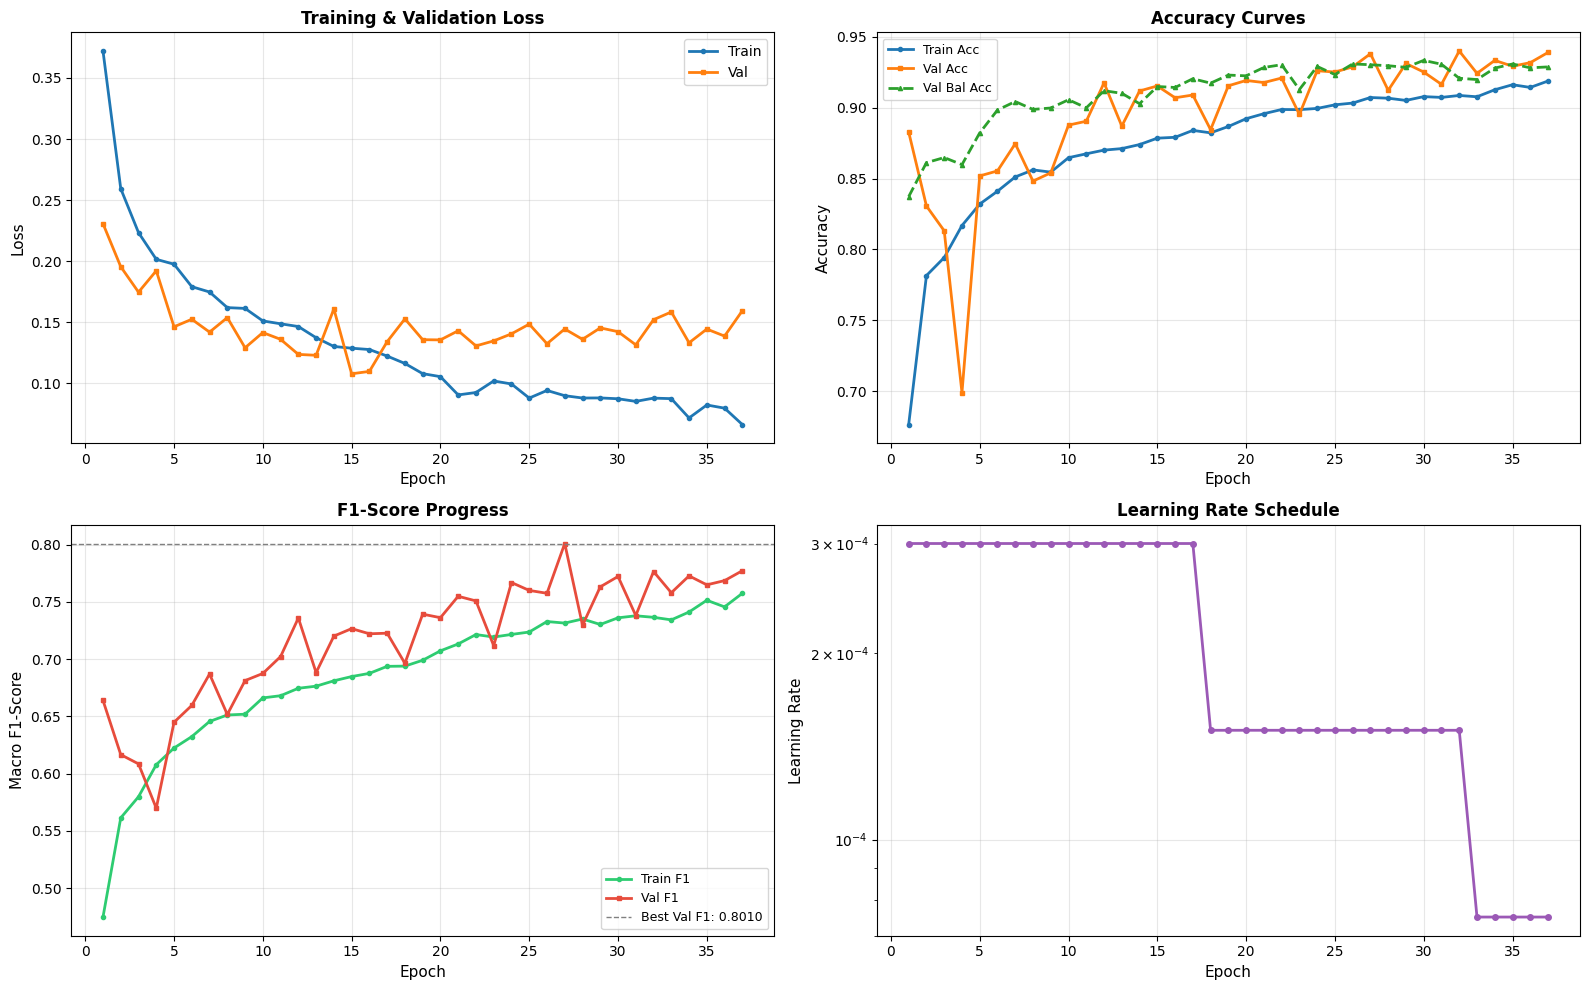

Saved: figures/training_curves.png


In [ ]:
# 1. Training curves
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

epochs = [h['epoch'] for h in history]

# Loss
ax = axes[0, 0]
ax.plot(epochs, [h['train_loss'] for h in history], label='Train', marker='o', markersize=3, linewidth=2)
ax.plot(epochs, [h['val_loss'] for h in history], label='Val', marker='s', markersize=3, linewidth=2)
ax.set_xlabel('Epoch', fontsize=11)
ax.set_ylabel('Loss', fontsize=11)
ax.set_title('Training & Validation Loss', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

# Accuracy
ax = axes[0, 1]
ax.plot(epochs, [h['train_acc'] for h in history], label='Train Acc', marker='o', markersize=3, linewidth=2)
ax.plot(epochs, [h['val_acc'] for h in history], label='Val Acc', marker='s', markersize=3, linewidth=2)
ax.plot(epochs, [h['val_bal_acc'] for h in history], label='Val Bal Acc', marker='^', markersize=3, linewidth=2, linestyle='--')
ax.set_xlabel('Epoch', fontsize=11)
ax.set_ylabel('Accuracy', fontsize=11)
ax.set_title('Accuracy Curves', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(alpha=0.3)

# F1 Score
ax = axes[1, 0]
ax.plot(epochs, [h['train_f1'] for h in history], label='Train F1', marker='o', markersize=3, linewidth=2, color='#2ecc71')
ax.plot(epochs, [h['val_f1'] for h in history], label='Val F1', marker='s', markersize=3, linewidth=2, color='#e74c3c')
ax.axhline(y=best_val_f1, color='gray', linestyle='--', linewidth=1, label=f'Best Val F1: {best_val_f1:.4f}')
ax.set_xlabel('Epoch', fontsize=11)
ax.set_ylabel('Macro F1-Score', fontsize=11)
ax.set_title('F1-Score Progress', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(alpha=0.3)

# Learning Rate
ax = axes[1, 1]
ax.plot(epochs, [h['lr'] for h in history], marker='o', markersize=4, linewidth=2, color='#9b59b6')
ax.set_xlabel('Epoch', fontsize=11)
ax.set_ylabel('Learning Rate', fontsize=11)
ax.set_title('Learning Rate Schedule', fontsize=12, fontweight='bold')
ax.set_yscale('log')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'training_curves.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: figures/training_curves.png')

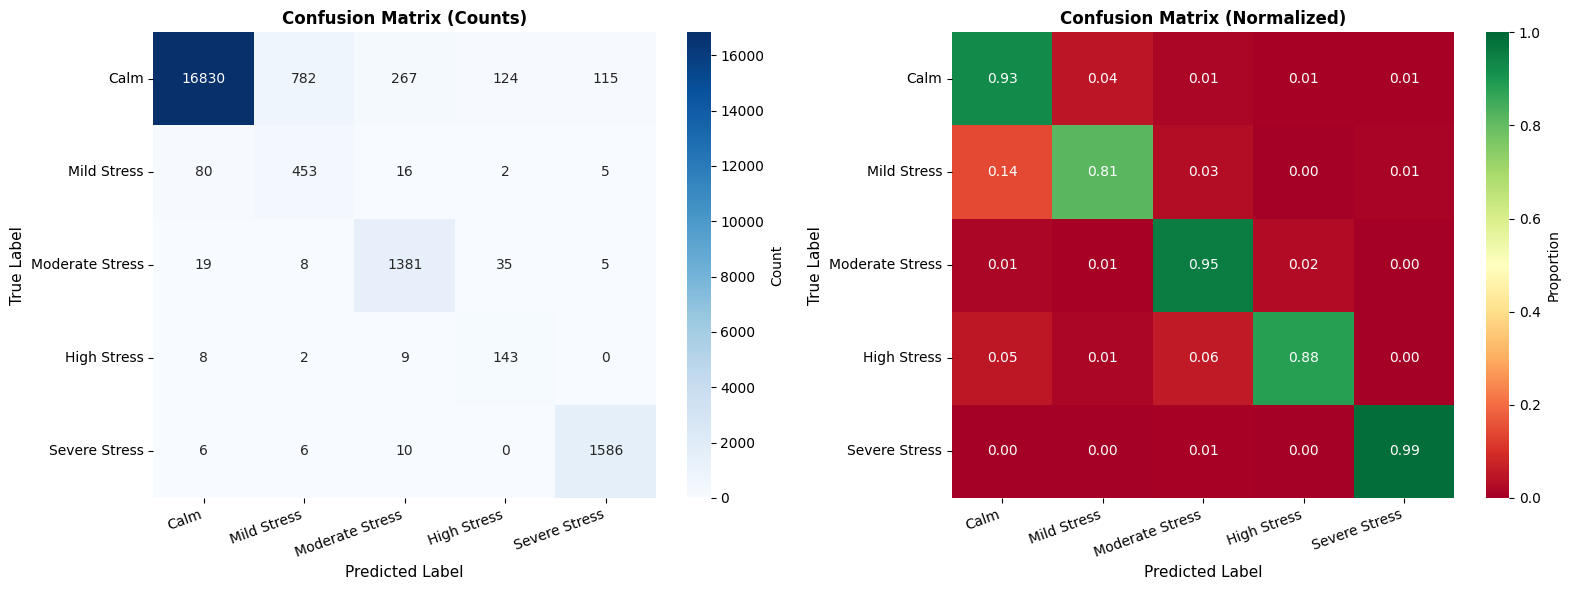

Saved: figures/confusion_matrix.png


In [ ]:
# 2. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES, ax=ax1, cbar_kws={'label': 'Count'})
ax1.set_ylabel('True Label', fontsize=11)
ax1.set_xlabel('Predicted Label', fontsize=11)
ax1.set_title('Confusion Matrix (Counts)', fontsize=12, fontweight='bold')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=20, ha='right')

# Normalized
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='RdYlGn', xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES, ax=ax2, vmin=0, vmax=1, cbar_kws={'label': 'Proportion'})
ax2.set_ylabel('True Label', fontsize=11)
ax2.set_xlabel('Predicted Label', fontsize=11)
ax2.set_title('Confusion Matrix (Normalized)', fontsize=12, fontweight='bold')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=20, ha='right')

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'confusion_matrix.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: figures/confusion_matrix.png')

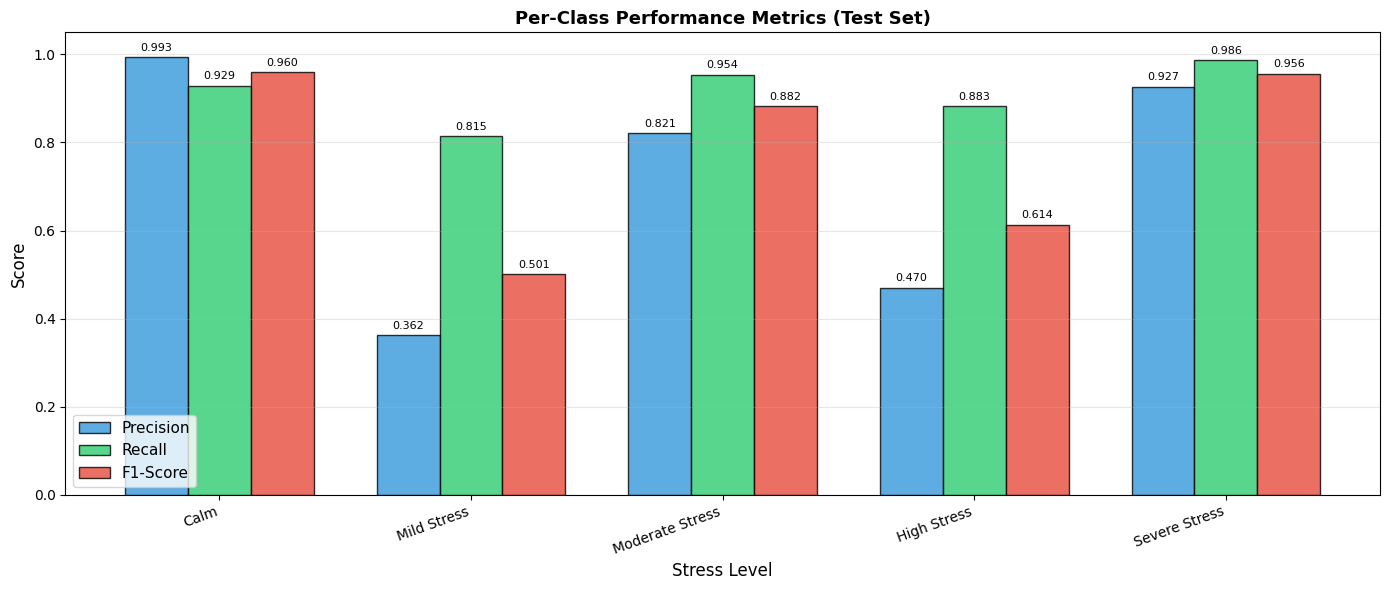

Saved: figures/per_class_metrics.png


In [ ]:
# 3. Per-Class Performance
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(NUM_CLASSES)
width = 0.25

bars1 = ax.bar(x - width, precision, width, label='Precision', color='#3498db', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x, recall, width, label='Recall', color='#2ecc71', alpha=0.8, edgecolor='black')
bars3 = ax.bar(x + width, f1_per_class, width, label='F1-Score', color='#e74c3c', alpha=0.8, edgecolor='black')

ax.set_xlabel('Stress Level', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Per-Class Performance Metrics (Test Set)', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(CLASS_NAMES, rotation=20, ha='right')
ax.legend(fontsize=11)
ax.set_ylim(0, 1.05)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

autolabel(bars1)
autolabel(bars2)
autolabel(bars3)

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'per_class_metrics.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: figures/per_class_metrics.png')

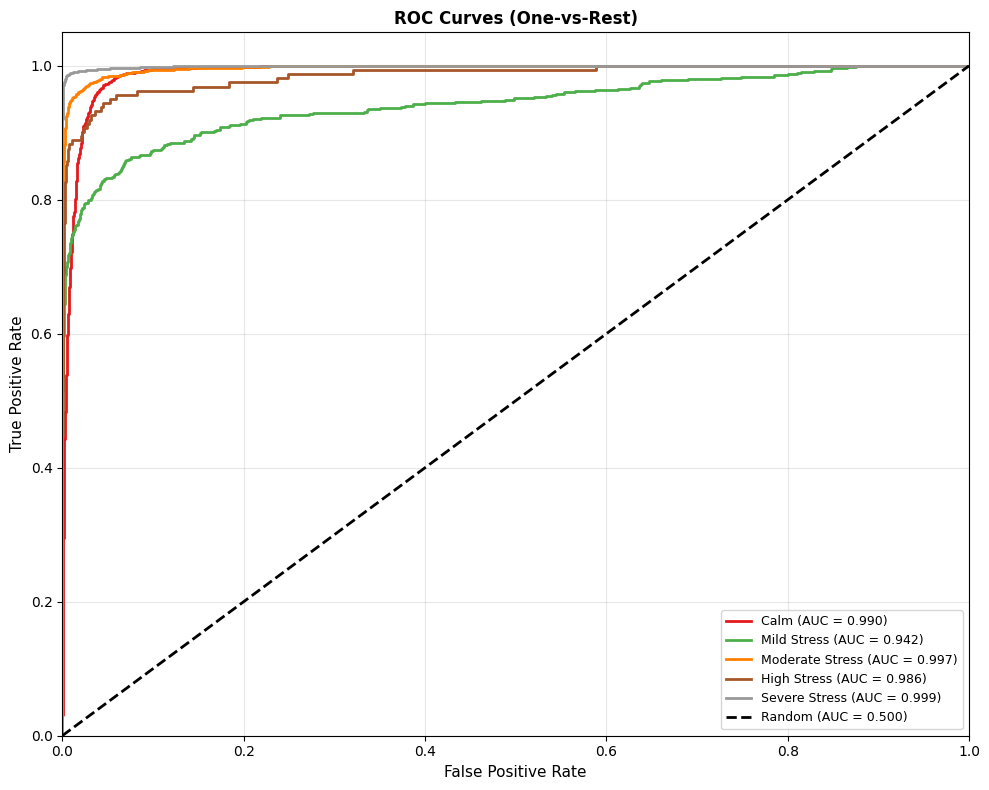

Saved: figures/roc_curves.png


In [ ]:
# 4. ROC Curves (One-vs-Rest)
from sklearn.preprocessing import label_binarize

y_true_bin = label_binarize(y_true, classes=range(NUM_CLASSES))

fig, ax = plt.subplots(figsize=(10, 8))
colors = plt.cm.Set1(np.linspace(0, 1, NUM_CLASSES))

for i, (color, cls) in enumerate(zip(colors, CLASS_NAMES)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc = roc_auc_score(y_true_bin[:, i], y_probs[:, i])
    ax.plot(fpr, tpr, color=color, lw=2, label=f'{cls} (AUC = {roc_auc:.3f})')

ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.500)')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=11)
ax.set_ylabel('True Positive Rate', fontsize=11)
ax.set_title('ROC Curves (One-vs-Rest)', fontsize=12, fontweight='bold')
ax.legend(loc='lower right', fontsize=9)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'roc_curves.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: figures/roc_curves.png')

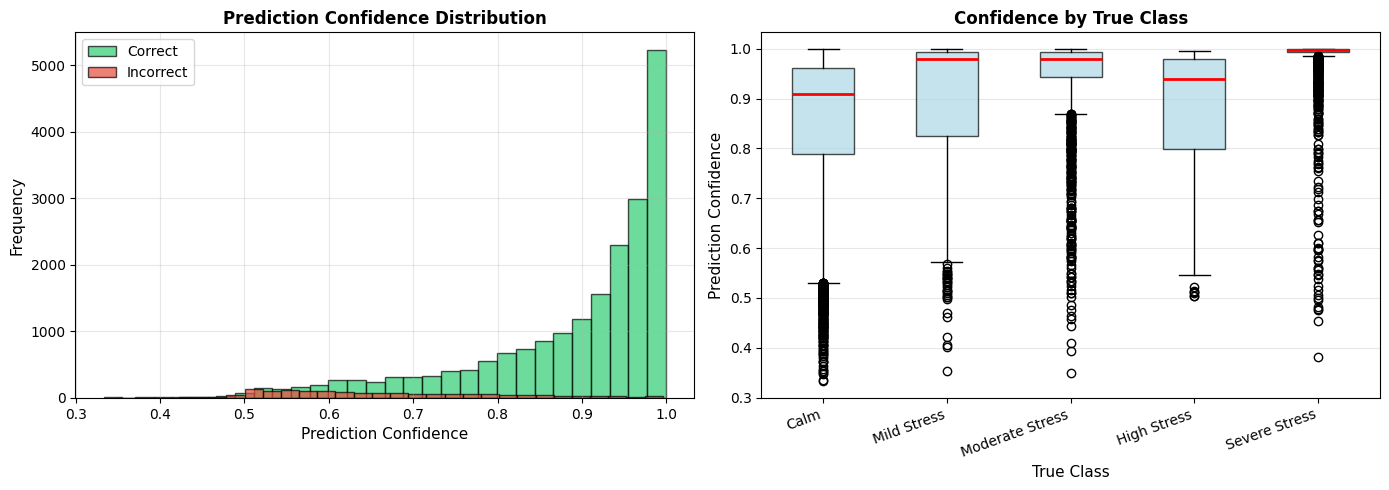

Saved: figures/confidence_analysis.png


In [ ]:
# 5. Prediction confidence distribution
confidence = np.max(y_probs, axis=1)
correct = (y_pred == y_true)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall confidence distribution
ax = axes[0]
ax.hist(confidence[correct], bins=30, alpha=0.7, label='Correct', color='#2ecc71', edgecolor='black')
ax.hist(confidence[~correct], bins=30, alpha=0.7, label='Incorrect', color='#e74c3c', edgecolor='black')
ax.set_xlabel('Prediction Confidence', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('Prediction Confidence Distribution', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

# Confidence by class
ax = axes[1]
conf_by_class = [confidence[y_true == i] for i in range(NUM_CLASSES)]
bp = ax.boxplot(conf_by_class, labels=CLASS_NAMES, patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                medianprops=dict(color='red', linewidth=2))
ax.set_xlabel('True Class', fontsize=11)
ax.set_ylabel('Prediction Confidence', fontsize=11)
ax.set_title('Confidence by True Class', fontsize=12, fontweight='bold')
ax.set_xticklabels(CLASS_NAMES, rotation=20, ha='right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'confidence_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: figures/confidence_analysis.png')

## 8. Save Results and Model Info

In [ ]:
# Save comprehensive results
results = {
    'model': 'NeuroFusionGPT',
    'architecture': {
        'eeg_features': EEG_FEATURES,
        'ecg_features': ECG_FEATURES,
        'd_model': 128,
        'num_classes': NUM_CLASSES,
        'total_params': total_params
    },
    'training': {
        'epochs_run': len(history),
        'best_epoch': best_epoch,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'optimizer': 'AdamW',
        'loss': 'FocalLoss'
    },
    'test_metrics': {
        'accuracy': float(test_acc),
        'balanced_accuracy': float(test_bal_acc),
        'macro_f1': float(test_f1),
        'loss': float(test_loss)
    },
    'per_class_metrics': {
        CLASS_NAMES[i]: {
            'precision': float(precision[i]),
            'recall': float(recall[i]),
            'f1_score': float(f1_per_class[i])
        } for i in range(NUM_CLASSES)
    },
    'confusion_matrix': cm.tolist(),
    'class_names': CLASS_NAMES
}

# Save results JSON
with open(os.path.join(OUTPUT_DIR, 'fusion_results.json'), 'w') as f:
    json.dump(results, f, indent=2)

# Save training history
with open(os.path.join(OUTPUT_DIR, 'training_history.json'), 'w') as f:
    json.dump(history, f, indent=2)

# Save model configuration
config = {
    'eeg_features': EEG_FEATURES,
    'ecg_features': ECG_FEATURES,
    'd_model': 128,
    'num_classes': NUM_CLASSES,
    'class_names': CLASS_NAMES,
    'scaler_eeg_path': 'scaler_eeg.pkl',
    'scaler_ecg_path': 'scaler_ecg.pkl',
    'model_path': 'best_fusion_model.pth'
}

with open(os.path.join(OUTPUT_DIR, 'model_config.json'), 'w') as f:
    json.dump(config, f, indent=2)

print('\n' + '='*80)
print('ALL RESULTS SAVED')
print('='*80)
print(f'Output directory: {OUTPUT_DIR}\n')
print('Files saved:')
print('  - best_fusion_model.pth (trained model checkpoint)')
print('  - scaler_eeg.pkl, scaler_ecg.pkl (preprocessing scalers)')
print('  - fusion_results.json (comprehensive metrics)')
print('  - training_history.json (epoch-by-epoch history)')
print('  - model_config.json (architecture and paths)')
print('\nFigures:')
print('  - figures/data_eda.png')
print('  - figures/training_curves.png')
print('  - figures/confusion_matrix.png')
print('  - figures/per_class_metrics.png')
print('  - figures/roc_curves.png')
print('  - figures/confidence_analysis.png')
print('='*80)


ALL RESULTS SAVED
Output directory: /content/drive/MyDrive/models/bindu/

Files saved:
  - best_fusion_model.pth (trained model checkpoint)
  - scaler_eeg.pkl, scaler_ecg.pkl (preprocessing scalers)
  - fusion_results.json (comprehensive metrics)
  - training_history.json (epoch-by-epoch history)
  - model_config.json (architecture and paths)

Figures:
  - figures/data_eda.png
  - figures/training_curves.png
  - figures/confusion_matrix.png
  - figures/per_class_metrics.png
  - figures/roc_curves.png
  - figures/confidence_analysis.png
